In [1]:
import pandas as pd
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pickle


In [2]:
from allosaurus.app import read_recognizer

# load your model
model = read_recognizer()

# run inference -> æ l u s ɔ ɹ s
model.recognize('sample.wav')

'æ l u s ɔ ɹ s'

In [3]:
from collections import defaultdict
def add_dicts(*dicts):
    result = defaultdict(int)
    for d in dicts:
        for key, value in d.items():
            result[key] += value
    return dict(result)

def normalize_dict(dict, size):
    normalized_dict={}
    for key in dict:
        normalized_dict[key] = dict[key]/size
    return normalized_dict

def save_dict(dictionary, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dictionary, f)

# Function to load dictionary from a file
def load_dict(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None

In [4]:
from allosaurus.app import read_recognizer
from collections import Counter
import pandas

# load your model by the <model name>, will use 'latest' if left empty
model = read_recognizer()
folder_path="C:/Users/itsme/OneDrive/Documents/IITMandi_Readspeech/IITMandi_Readspeech/"
langs=['asm', 'ben', 'guj', 'kan', 'mal', 'tel', 'hin', 'odi']
normalized_dict={}
for lang in langs:
    dict_filename = f"{lang}_dictionary.pkl"
    existing_dict = load_dict(dict_filename)
    if existing_dict:
        print(f"Loaded existing dictionary for {lang}")
        normalized_dict[lang] = existing_dict
    else:
        net_count = {}
        files = os.listdir(os.path.join(folder_path, lang))
        size = len(files)
        print(f"number of files in {lang} is: {size}")
        for i in range(size):
            file = os.path.join(os.path.join(folder_path, lang), files[i])
            phonyms = model.recognize(file, timestamp=False).split()
            count = Counter(phonyms)
            net_count = add_dicts(net_count, count)
        
        normalized_dict[lang] = normalize_dict(net_count, size)
        save_dict(normalized_dict[lang], dict_filename)
        print(f"{lang} : {normalized_dict[lang]}")

print("All dictionaries processed and saved.")
    



Loaded existing dictionary for asm
Loaded existing dictionary for ben
Loaded existing dictionary for guj
Loaded existing dictionary for kan
Loaded existing dictionary for mal
Loaded existing dictionary for tel
Loaded existing dictionary for hin
Loaded existing dictionary for odi
All dictionaries processed and saved.


In [5]:
langs=['asm', 'ben', 'guj', 'kan', 'mal', 'tel', 'hin', 'odi']
normalized_dict={}
for lang in langs:
    dict_filename = f"{lang}_dictionary.pkl"
    normalized_dict[lang] = load_dict(dict_filename)
    if normalized_dict[lang]:
        print(f"Loaded dictionary for {lang}")

# Plot histograms for each language
for lang in langs:
    if normalized_dict[lang]:
        df = pd.DataFrame.from_dict(normalized_dict[lang], orient='index')
        df.plot(kind='bar', title=lang, figsize=(20, 16))
        plt.savefig(f"{lang}.png")
        plt.close()  # Close the plot to avoid display in interactive environments

print("All histograms generated and saved.")

Loaded dictionary for asm
Loaded dictionary for ben
Loaded dictionary for guj
Loaded dictionary for kan
Loaded dictionary for mal
Loaded dictionary for tel
Loaded dictionary for hin
Loaded dictionary for odi
All histograms generated and saved.


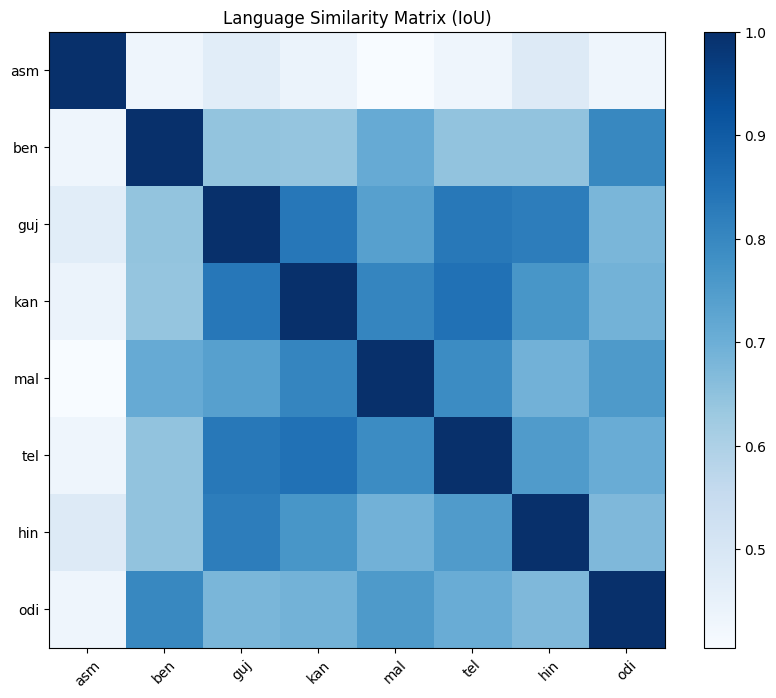

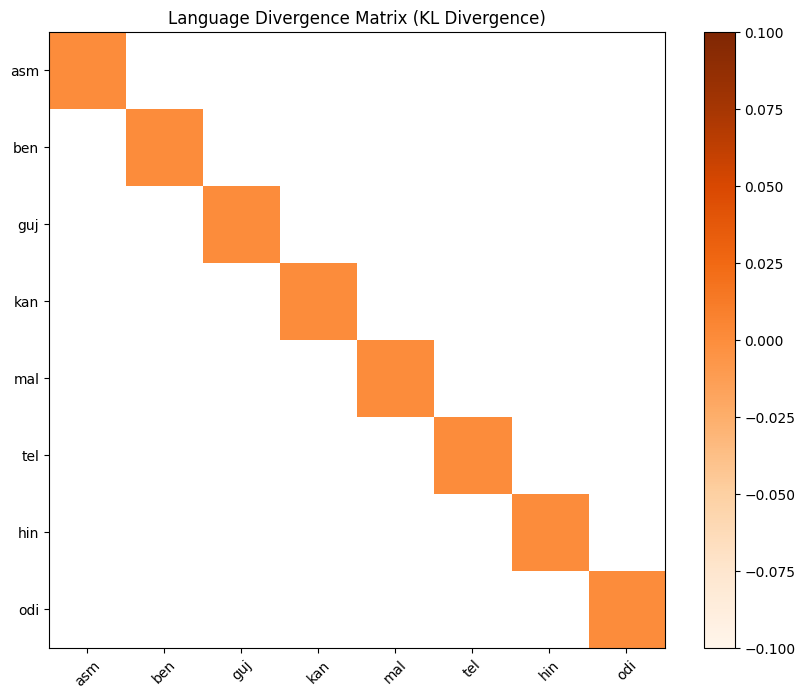

Similarity and divergence matrices calculated and saved.


In [6]:
from scipy.special import rel_entr
def calculate_iou(dict1, dict2):
    intersection = sum(min(dict1.get(k, 0), dict2.get(k, 0)) for k in set(dict1) | set(dict2))
    union = sum(max(dict1.get(k, 0), dict2.get(k, 0)) for k in set(dict1) | set(dict2))
    return intersection / union if union != 0 else 0

def calculate_kl_divergence(dict1, dict2):
    keys = set(dict1.keys()).union(dict2.keys())
    p = np.array([dict1.get(k, 0) for k in keys])
    q = np.array([dict2.get(k, 0) for k in keys])
    
    # Normalize to ensure p and q are probability distributions
    p /= p.sum()
    q /= q.sum()

    # Calculate KL divergence using scipy's rel_entr
    kl_div = np.sum(rel_entr(p, q))

    return kl_div

# Calculate similarity matrices
iou_similarity_matrix = np.zeros((len(langs), len(langs)))
kl_divergence_matrix = np.zeros((len(langs), len(langs)))

for i, lang1 in enumerate(langs):
    for j, lang2 in enumerate(langs):
        if i != j and normalized_dict[lang1] and normalized_dict[lang2]:
            iou_similarity_matrix[i, j] = calculate_iou(normalized_dict[lang1], normalized_dict[lang2])
            kl_divergence_matrix[i, j] = calculate_kl_divergence(normalized_dict[lang1], normalized_dict[lang2])
        else:
            iou_similarity_matrix[i, j] = 1.0 if i == j else 0.0
            kl_divergence_matrix[i, j] = 0.0 if i == j else np.nan

# Convert matrices to DataFrame for better display
iou_similarity_df = pd.DataFrame(iou_similarity_matrix, index=langs, columns=langs)
kl_divergence_df = pd.DataFrame(kl_divergence_matrix, index=langs, columns=langs)

# Plot the IoU similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(iou_similarity_df, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(len(langs)), langs, rotation=45)
plt.yticks(np.arange(len(langs)), langs)
plt.title('Language Similarity Matrix (IoU)')
plt.savefig('language_similarity_matrix_iou.png')
plt.show()

# Plot the KL divergence matrix
plt.figure(figsize=(10, 8))
plt.imshow(kl_divergence_df, interpolation='nearest', cmap='Oranges')
plt.colorbar()
plt.xticks(np.arange(len(langs)), langs, rotation=45)
plt.yticks(np.arange(len(langs)), langs)
plt.title('Language Divergence Matrix (KL Divergence)')
plt.savefig('language_divergence_matrix_kl.png')
plt.show()

print("Similarity and divergence matrices calculated and saved.")

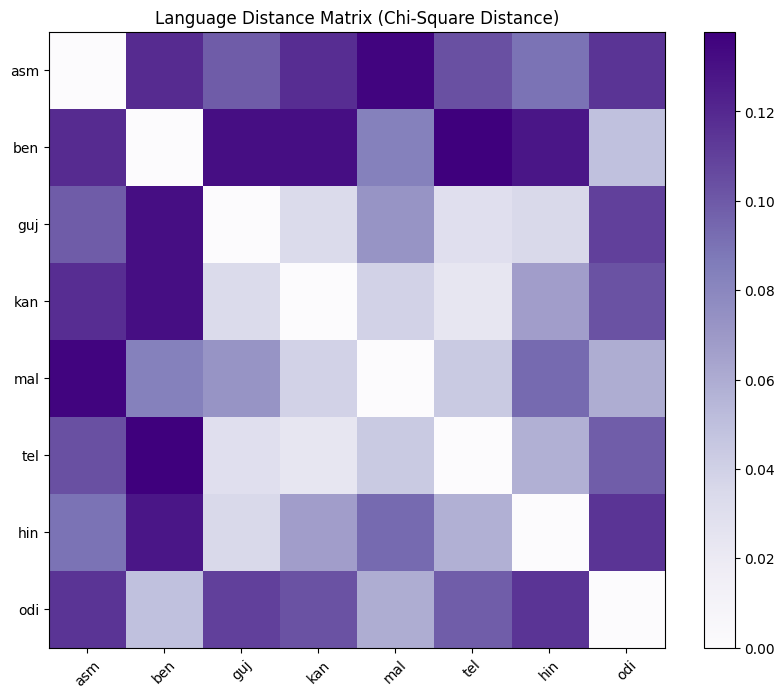

Chi-square distance matrix calculated and saved.


In [7]:


# Function to calculate chi-square distance
def calculate_chi_square_distance(dict1, dict2):
    keys = set(dict1.keys()).union(dict2.keys())
    p = np.array([dict1.get(k, 0) for k in keys])
    q = np.array([dict2.get(k, 0) for k in keys])
    
    # Normalize to ensure p and q are probability distributions
    p /= p.sum()
    q /= q.sum()

    # Calculate chi-square distance
    chi_square = np.sum(((p - q) ** 2) / (p + q + 1e-10))  # Add small epsilon to avoid division by zero

    return chi_square

# Calculate chi-square distance matrix
chi_square_distance_matrix = np.zeros((len(langs), len(langs)))

for i, lang1 in enumerate(langs):
    for j, lang2 in enumerate(langs):
        if i != j and normalized_dict[lang1] and normalized_dict[lang2]:
            chi_square_distance_matrix[i, j] = calculate_chi_square_distance(normalized_dict[lang1], normalized_dict[lang2])
        else:
            chi_square_distance_matrix[i, j] = 0.0

# Convert matrix to DataFrame for better display
chi_square_distance_df = pd.DataFrame(chi_square_distance_matrix, index=langs, columns=langs)

# Plot the chi-square distance matrix
plt.figure(figsize=(10, 8))
plt.imshow(chi_square_distance_df, interpolation='nearest', cmap='Purples')
plt.colorbar()
plt.xticks(np.arange(len(langs)), langs, rotation=45)
plt.yticks(np.arange(len(langs)), langs)
plt.title('Language Distance Matrix (Chi-Square Distance)')
plt.savefig('language_distance_matrix_chi_square.png')
plt.show()

print("Chi-square distance matrix calculated and saved.")


In [8]:
!python -m allosaurus.bin.list_lang

Available Languages
- ISO639-3:  kor Glotto Code kore1280  name:  b'korean'
- ISO639-3:  ket Glotto Code kett1243  name:  b'ket'
- ISO639-3:  lbe Glotto Code lakk1252  name:  b'lak'
- ISO639-3:  kbd Glotto Code kaba1278  name:  b'kabardian'
- ISO639-3:  kat Glotto Code nucl1302  name:  b'georgian'
- ISO639-3:  bsk Glotto Code buru1296  name:  b'burushaski'
- ISO639-3:  kru Glotto Code kuru1302  name:  b'kurukh'
- ISO639-3:  tel Glotto Code telu1262  name:  b'telugu'
- ISO639-3:  kfe Glotto Code kota1263  name:  b'kota'
- ISO639-3:  unr Glotto Code mund1320  name:  b'mundari'
- ISO639-3:  khr Glotto Code khar1287  name:  b'kharia'
- ISO639-3:  kha Glotto Code khas1269  name:  b'khasi'
- ISO639-3:  sed Glotto Code seda1262  name:  b'sedang'
- ISO639-3:  khm Glotto Code cent1989  name:  b'cambodian'
- ISO639-3:  vie Glotto Code viet1252  name:  b'vietnamese'
- ISO639-3:  cmn Glotto Code mand1415  name:  b'mandarin chinese'
- ISO639-3:  wuu Glotto Code wuch1236  name:  b'wu'
- ISO639-3:  h